# Model validation water levels

Note: this notebook requires the model output data

<div class="alert alert-warning" role="alert">
  <strong>⚠️ Important Disclaimer</strong><br><br>
  This model setup is a <strong>simplified version</strong> of a detailed model developed by DHI. It does <strong>not</strong> resolve fine-scale processes and is <strong>not calibrated</strong> for operational use. Use is limited to <strong>educational and research purposes only</strong> — results should <strong>not</strong> inform decision-making. Performance shown here does <strong>not</strong> represent that of DHI’s high-resolution models.
</div>

In [1]:
import mikeio
import modelskill as ms
import matplotlib.pyplot as plt 
import helper as h
import pandas as pd

In [2]:
ms.options.metrics.list = ["rmse", "mae", "cc", "si", "r2"]

Instead of reading the entire dfsu (`Area.dfsu`), we can simply load the outputted points (dfs0) since they correspond to the locations we have observations from.

In [23]:
#mr_fldr = "../output/"    
mr_fldr = "../output_sample/"     # use this if you have not downloaded the full data from Zenodo yet
save_png = False if "sample" in mr_fldr else True
fig_fldr = "../figures/" 

Model results data are stored in a dfs0 file. We can use [MIKE IO](https://dhi.github.io/mikeio) read the data to a MIKE IO Dataset.

Note: The first two spin-up days are excluded.

In [15]:
ds = mikeio.read(f"{mr_fldr}Points.dfs0", items="*Sign*", time = slice("2022-01-03", None))
ds.items

[6201045: Sign. Wave Height <Significant wave height> (meter),
 6201050: Sign. Wave Height <Significant wave height> (meter),
 6201059: Sign. Wave Height <Significant wave height> (meter),
 6201047: Sign. Wave Height <Significant wave height> (meter),
 A121_: Sign. Wave Height <Significant wave height> (meter),
 Europlatform2: Sign. Wave Height <Significant wave height> (meter),
 F3platform: Sign. Wave Height <Significant wave height> (meter),
 IJmuidenMunitiestort_: Sign. Wave Height <Significant wave height> (meter),
 J61: Sign. Wave Height <Significant wave height> (meter),
 K13a_: Sign. Wave Height <Significant wave height> (meter),
 L91_: Sign. Wave Height <Significant wave height> (meter),
 Nymindegab: Sign. Wave Height <Significant wave height> (meter),
 Oosterschelde11: Sign. Wave Height <Significant wave height> (meter),
 Q1_: Sign. Wave Height <Significant wave height> (meter),
 WaddenEierlandseGat: Sign. Wave Height <Significant wave height> (meter),
 WesthinderBuoy: Sign. W

## Compare to wave height station observations

The [ModelSkill package](https://dhi.github.io/modelskill/) can be used to compare model results with observations.

In [16]:
def get_swh_point_obs(obs_fldr, station_file):
    """Get wave height point observations as list of PointObservation objects"""
    q = ms.Quantity(name="Significant Wave Height", unit="meter")
    swhlist = []

    df_stn = pd.read_csv(obs_fldr + station_file, index_col=0)

    for i, row in df_stn.iterrows():
        df = pd.read_csv(obs_fldr + f"{i}.csv", index_col=0)
        df.index = pd.to_datetime(df.index, format="ISO8601")
        o = ms.PointObservation(df.VHM0, x=row['lon'], y=row['lat'], name=i, quantity=q)
        swhlist.append(o)

    return swhlist

In [17]:
swhlist = get_swh_point_obs(obs_fldr = "../observations/", station_file="current_stations.csv")
#swhlist

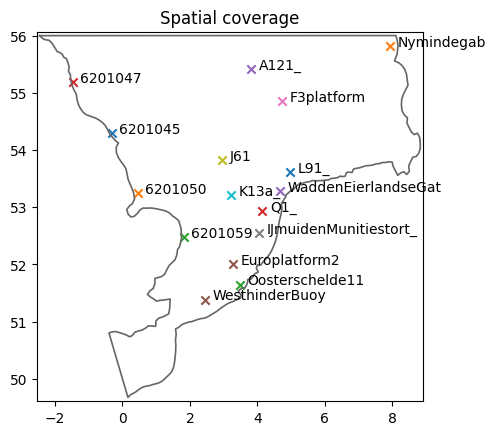

In [18]:
msh = mikeio.open("../input/Mesh_8000_elems.mesh")
ms.plotting.spatial_overview(swhlist, mod=msh);

Match the right model result timeseries and observation. Also, remove the bias (different vertical datum).

In [19]:
mr_fn = f"{mr_fldr}Area.dfsu"
mr = ms.DfsuModelResult(mikeio.read(mr_fn,time=slice("2022-01-03","2023-12-31"))[0], name="MIKE21")
cmps = []
for o in swhlist:
    mr = ms.PointModelResult(ds[o.name+": Sign. Wave Height"], name="MIKE21")
    try:
        cmp = ms.match(obs=o, mod=mr)
    except Exception as e:
        print(e)
    cmps.append(cmp.remove_bias())
cc = ms.ComparerCollection(cmps)

No data left after trimming to 2022-01-02 23:59:59 - 2022-01-03 23:50:01
No data left after trimming to 2022-01-02 23:59:59 - 2022-01-03 23:50:01


## Skill table

In [20]:
cc.skill().round(3)

,n,rmse,mae,cc,si,r2
observation,,,,,,
6201045,48,0.272,0.233,0.120,0.361,-0.311
6201050,48,0.150,0.122,0.573,0.205,-0.127
6201059,48,0.215,0.182,0.469,0.223,-1.032
6201047,48,0.246,0.209,0.347,0.339,0.088
A121_,144,0.388,0.318,0.798,0.136,0.127
Europlatform2,144,0.237,0.199,0.950,0.124,0.540
F3platform,144,0.357,0.288,0.847,0.111,0.423
IJmuidenMunitiestort_,144,0.195,0.155,0.943,0.088,0.731
J61,144,0.241,0.206,0.815,0.096,0.384


## Example timeseries

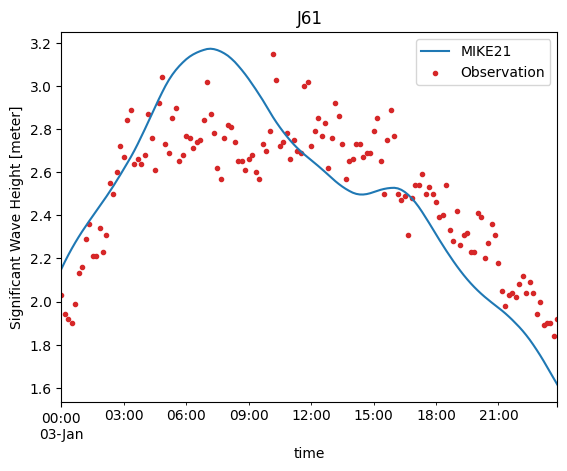

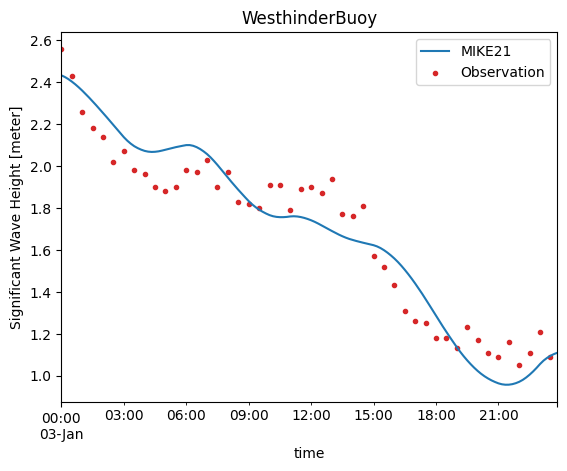

In [21]:
t_plot = slice("2022-12-01","2022-12-10") if "2022-12-01" in ds.time else slice(None, None)
cc["J61"].sel(time=t_plot).plot.timeseries();

cc["WesthinderBuoy"].sel(time=t_plot).plot.timeseries();

## Scatter plots

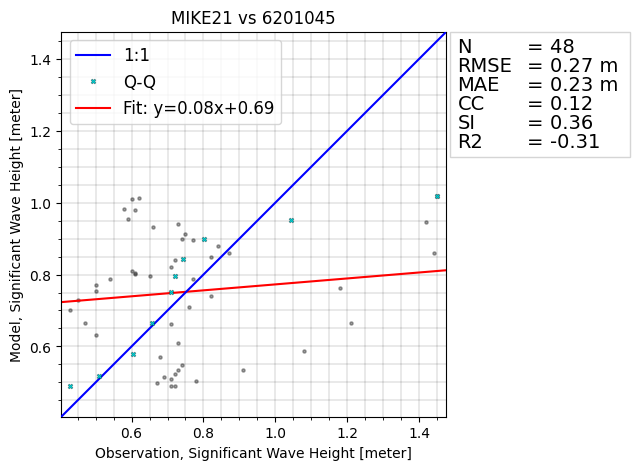

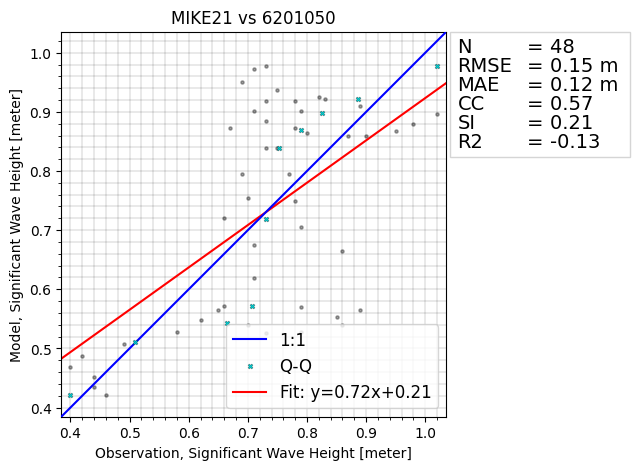

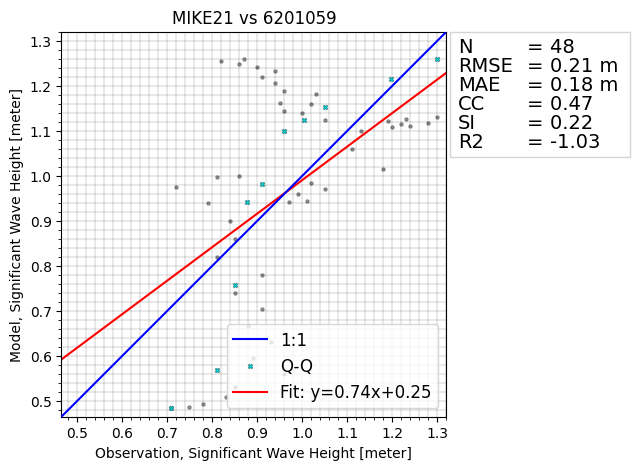

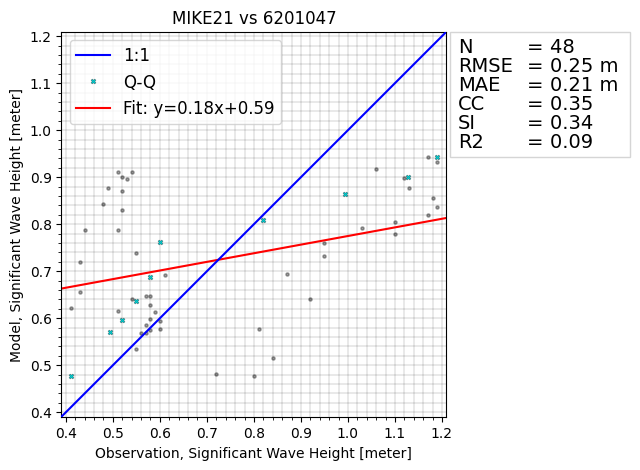

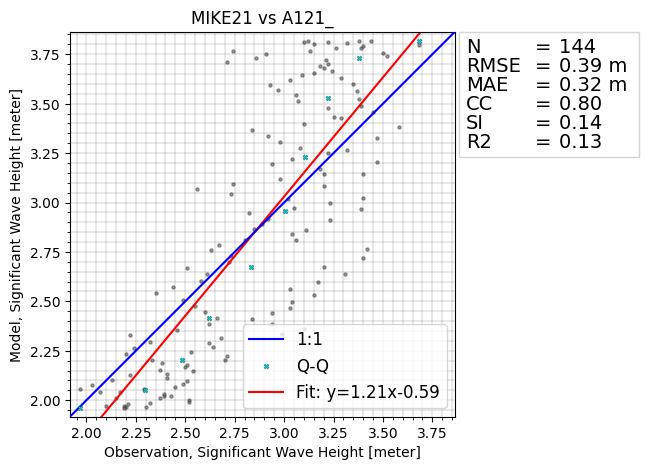

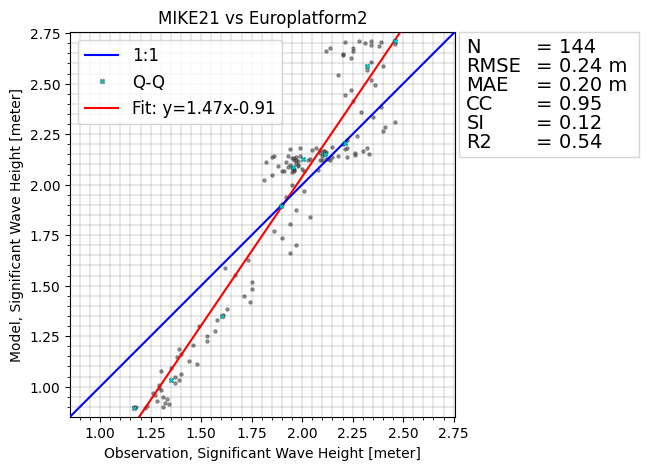

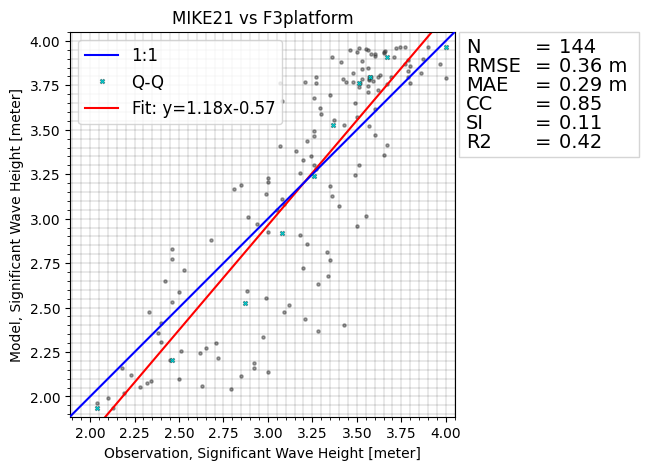

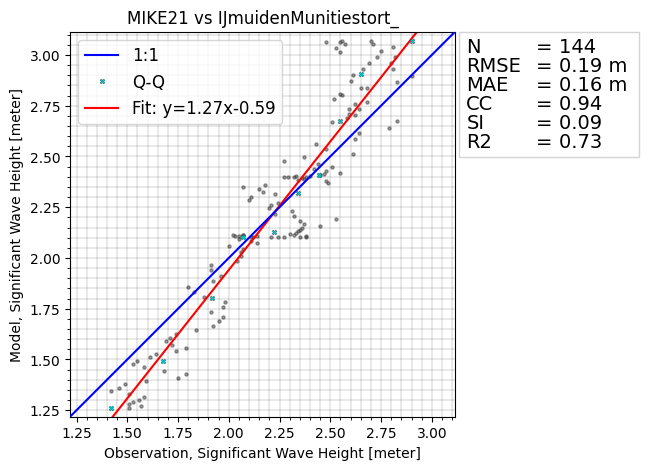

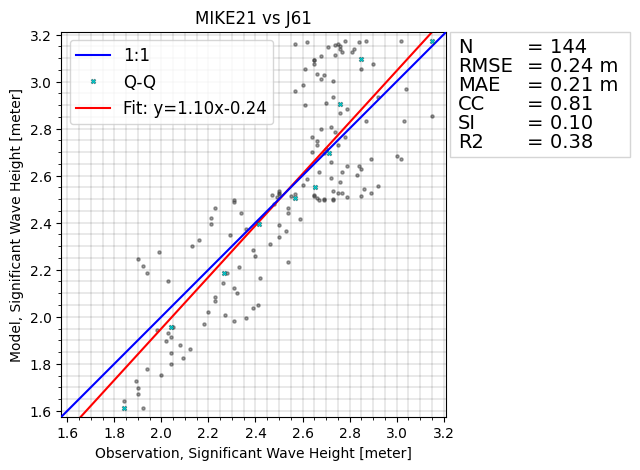

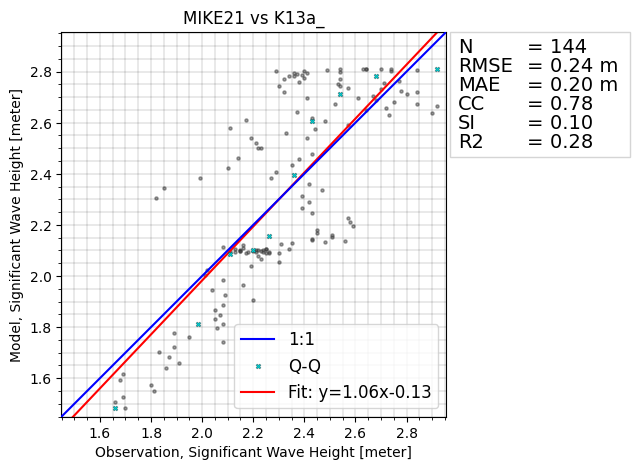

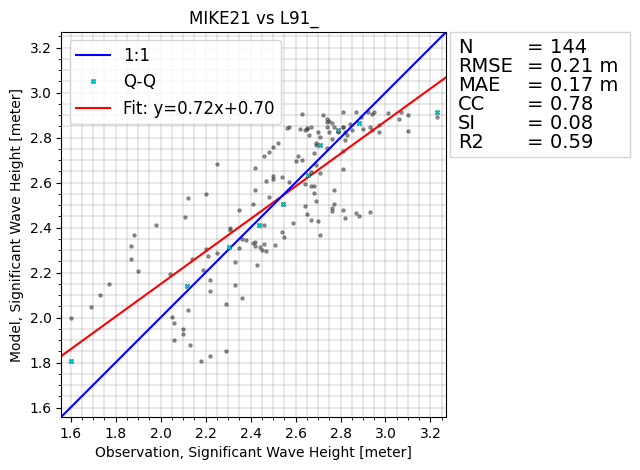

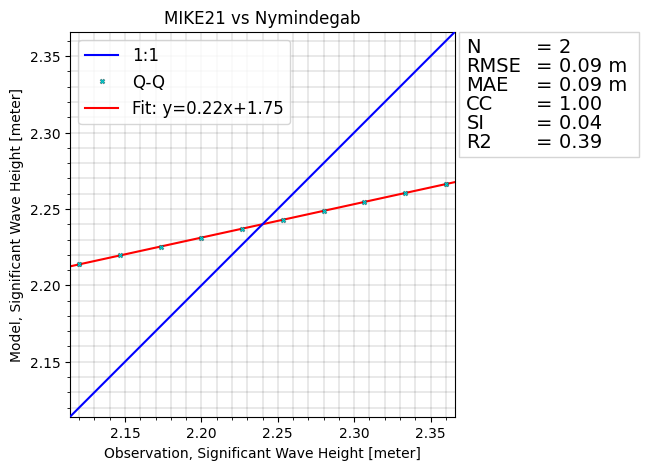

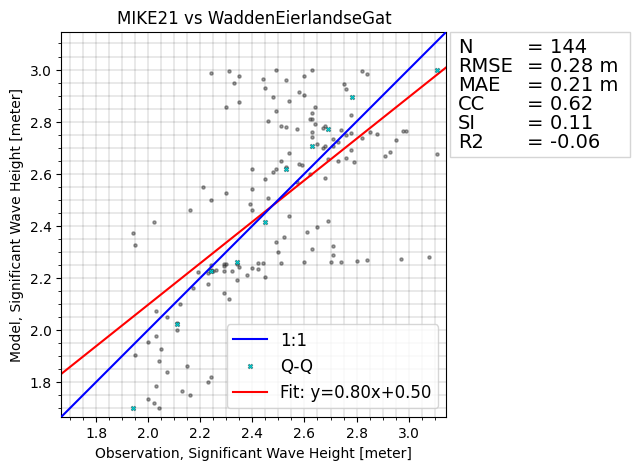

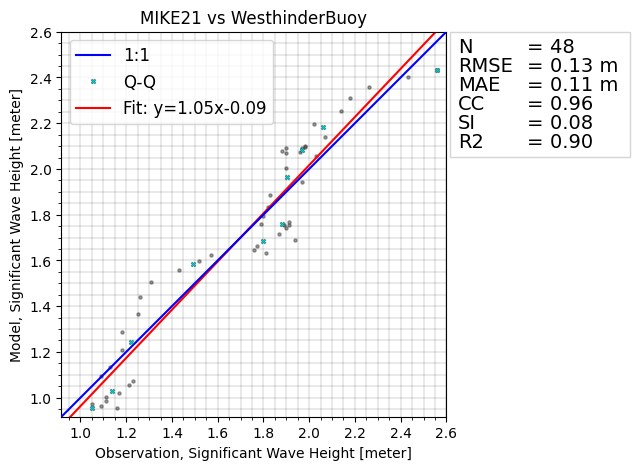

In [22]:
n_points_shown = 10000
for cmp in cc:
    cmp.plot.scatter(skill_table=True, show_points=n_points_shown, figsize=(6,5), bins=40);
    if save_png:
        plt.savefig(f"{fig_fldr}modelskill_comparison_{cmp.name}.png", bbox_inches='tight');